<a href="https://colab.research.google.com/github/Yashmaini30/Breast-Cancer-Detection/blob/main/ResNet50_on_Breast_Cancer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive, files
drive.mount('/content/drive')
from __future__ import absolute_import, print_function, division, unicode_literals
import os.path
import glob
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense, Activation,  GlobalAveragePooling2D
from keras import regularizers
import keras

import numpy as np
import matplotlib.pyplot as plt
import pathlib

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
data_dir = "/content/drive/MyDrive/archive"
data_dir = pathlib.Path(data_dir)

train_path = '/content/drive/MyDrive/archive/train'
test_path = '/content/drive/MyDrive/archive/test'

In [6]:
categories = os.listdir(train_path)
# Number of images for each disease
nums = {}
for lebal in categories:
    nums[lebal] = len(os.listdir(train_path + '/' + lebal))

# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
normal,212
malignant,336
benign,712


In [7]:
image_train_gen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.50,
                                     rotation_range=45,
                                     horizontal_flip=True,
                                     width_shift_range=0.15,
                                     height_shift_range=0.15)

train_data_gen = image_train_gen.flow_from_directory(train_path,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 1260 images belonging to 3 classes.


In [8]:
img_val_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = img_val_gen.flow_from_directory(test_path,
                                               batch_size=BATCH_SIZE,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='categorical')


Found 318 images belonging to 3 classes.


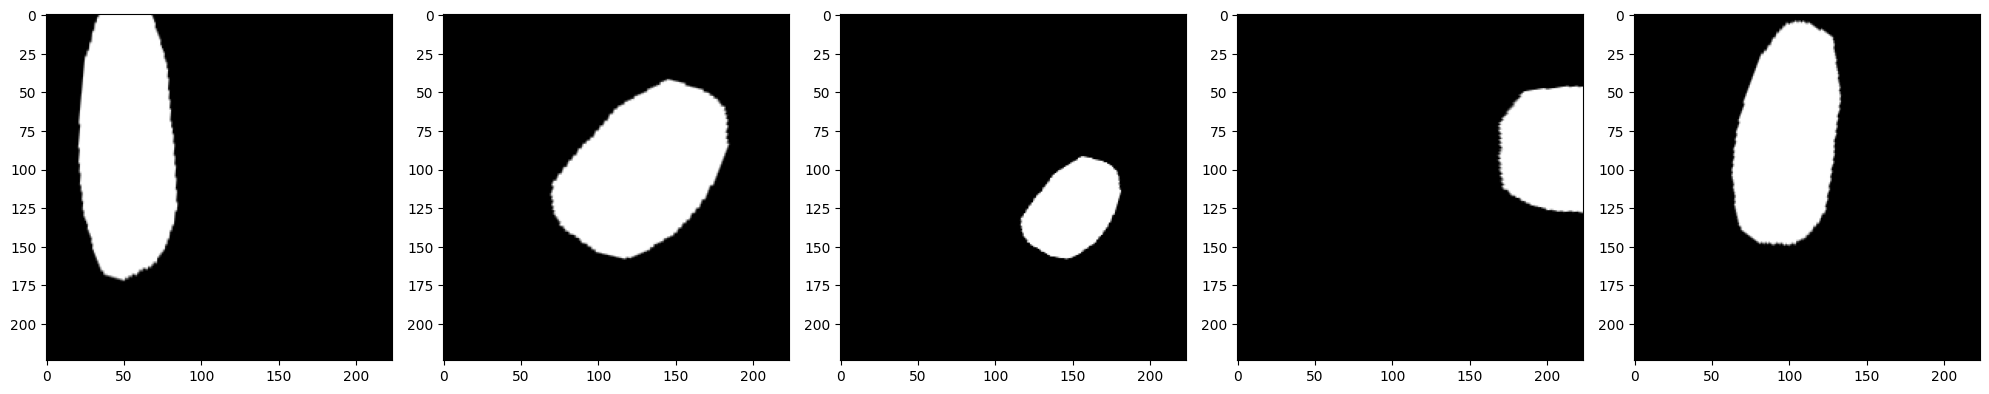

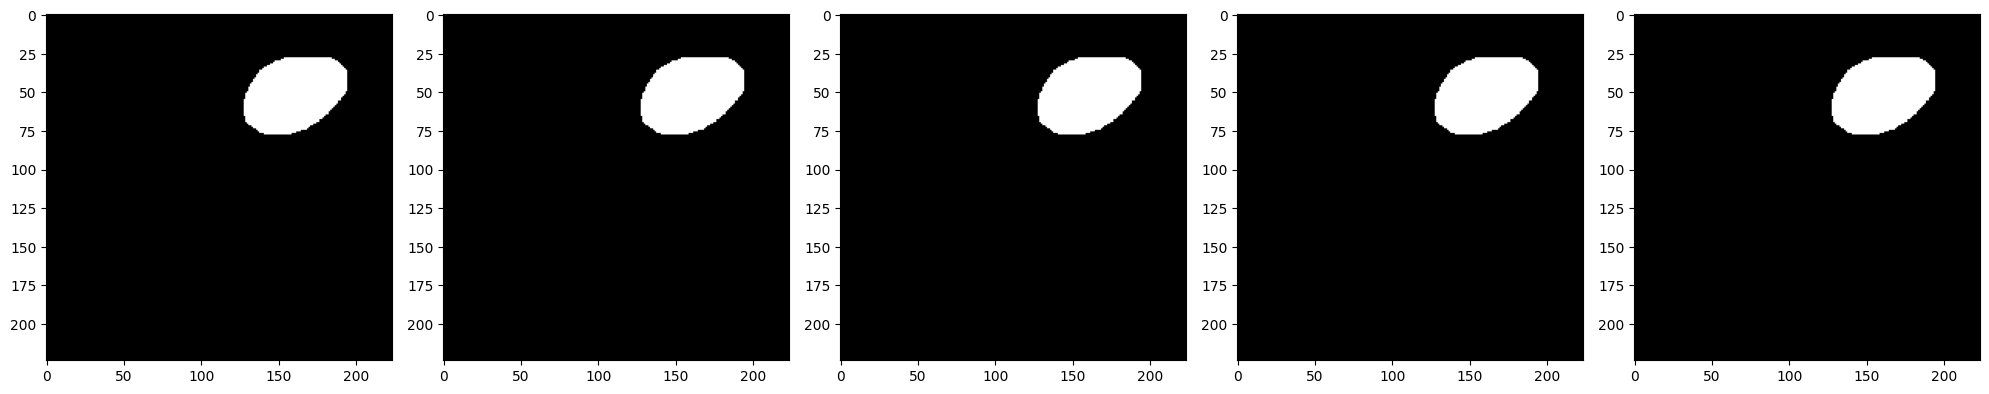

In [9]:
def plotImages(image_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Plot a few training images
img_array = [train_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)

# plot a few val images
img_array = [val_data_gen[0][0][0] for i in range(5)]
plotImages(img_array)


In [10]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                      include_top=False,
                      weights='imagenet')

# Freezing the base model
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(3, activation="softmax")(x)

# Building the model
model = Model(inputs=base_model.input, outputs=predictions)


In [29]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [30]:
EPOCHS = 10
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.5143 - loss: 1.0397 - val_accuracy: 0.6258 - val_loss: 0.8309
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.5863 - loss: 0.9202 - val_accuracy: 0.5660 - val_loss: 0.8696
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.5712 - loss: 0.9383 - val_accuracy: 0.6604 - val_loss: 0.8100
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.5969 - loss: 0.9059 - val_accuracy: 0.6667 - val_loss: 0.7768
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.6443 - loss: 0.8208 - val_accuracy: 0.6289 - val_loss: 0.7837
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.5907 - loss: 0.8453 - val_accuracy: 0.6572 - val_loss: 0.7477
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.6286 - loss: 0.8151 - val_accuracy: 0.6572 - val_loss: 0.7356
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.6117 - loss: 0.8377 - val_accuracy: 0.660

In [31]:
val_loss, val_acc = model.evaluate(val_data_gen)
print("Validation Accuracy: ", val_acc)


40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.7252 - loss: 0.7098
Validation Accuracy:  0.704402506351471


In [36]:
true_classes = val_data_gen.classes
CLASS_NAMES = ['benign', 'malignant', 'normal']

In [37]:
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix: \n", conf_matrix)

Accuracy:  0.42452830188679247
Precision:  0.4180677719571827
Recall:  0.42452830188679247
              precision    recall  f1-score   support

      benign       0.58      0.62      0.60       179
   malignant       0.24      0.09      0.14        85
      normal       0.17      0.30      0.22        54

    accuracy                           0.42       318
   macro avg       0.33      0.34      0.32       318
weighted avg       0.42      0.42      0.41       318

Confusion Matrix: 
 [[111  20  48]
 [ 49   8  28]
 [ 33   5  16]]


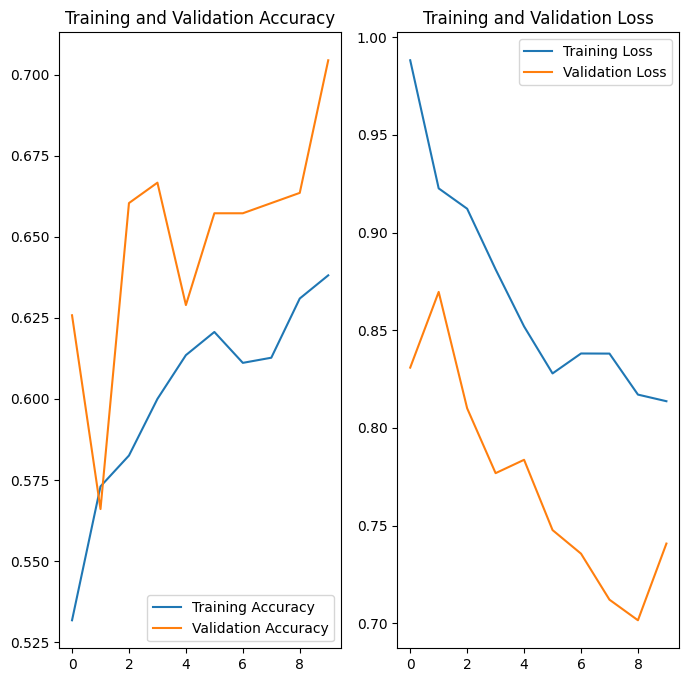

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()